### Random Forest Classification Model
run Random Forest and LinearCSV Classifier<br>
1. runs through the classification models to train/text authored data<br>
2. curiam decisions are then classified using Random Forest model<br>


In [58]:
import numpy as np
import pandas as pd
import random

from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, multilabel_confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# import custom classification methods
from utils.classification import (
    add_names,
    closest_value,
    get_mean_accuracy_model,
    get_best_accuracy_model,
    run_100,
    run_cross_validation,
    chart_results,
    chart_per_curiams,
    predict_per_curiams,
    get_classification_report
)


%matplotlib inline

In [2]:
# set seaborn color pallete
sns.set(color_codes=True)
sns.set_palette("muted")

In [3]:
# directory and file path definitions
# this assumes the notebook is run from the top level directory

base_data_path = Path.cwd() / 'data'
csv_path = base_data_path / 'csv'

authored_engineered_data_csv = csv_path / 'authored_engineered_data.csv'
curiam_engineered_data_csv = csv_path / 'curiam_engineered_data.csv'
json_path = base_data_path / 'json'
patterns_json = json_path / 'patterns.json'
function_words_json = json_path / 'function_words.json'

In [4]:
# read the engineered authored data
engineered_df = pd.read_csv(authored_engineered_data_csv, index_col=False)
engineered_df.head(3)

,case,justice,text,text_count,token_count,sentence_count,sentence_length_mean,sentence_length_std,unique_terms,sw_pct,...,fw_nothing,fw_whenever,fw_bar,fw_save,fw_when,fw_whichever,fw_anyone,fw_for,fw_i,avg_word_length
0,case-565-452,Kagan,The Federal Meat Inspection Act (FMIA or Act)...,24274,3756,179,20.66,11.60,924,46.19,...,1,0,1,0,6,0,0,42,2,5.162
1,case-575-13-1019,Kagan,"Before suing an employer for discrimination, ...",24032,3750,169,21.49,11.78,965,46.43,...,3,1,1,0,9,0,0,37,5,4.978
2,case-578-15-339,Kagan,The Prison Reform Act of (PLRA) s that an inm...,23533,3638,161,21.66,11.49,982,44.31,...,0,0,2,0,15,0,0,23,5,5.069


#### setup
configure data for classification

In [5]:
# justices are the target variable so we need to factorize them
# first, let's create the justice mapping (to be used later)
justice_names = engineered_df.justice.unique().tolist()
justice_int = [x for x in range(len(justice_names))]
justices_map = dict(zip(justice_int, justice_names))

In [6]:
# now, let's factorize the justice column
engineered_df.justice = pd.factorize(engineered_df.justice)[0]

In [7]:
# only going to use numerical data columns, so let's exclude the rest from the features list
exclude =  ['justice','case','text','entity_list', 'function_words']
target = 'justice'
features = [c for c in engineered_df.columns if c not in exclude]
X = engineered_df[features]
y = engineered_df.justice

In [8]:
# configure per curiam data for classification
curiam_df = pd.read_csv(curiam_engineered_data_csv)
exclude =  ['justice','case','text','entity_list', 'function_words']
curiam_features = [c for c in curiam_df.columns if c not in exclude]
curiam_predict_df = curiam_df[curiam_features]

#### Base Line
We are going to start by running and comparing 12 classifiers to get an initial sense of each classifiers accuracy. The cell will be rerun several times and the top classifiers will be chosen for further use.<br><br> ***NOTE***: the code is not my own. It is borrowed from Kaggle and modified to fit my purposes. I included LinearSVC and MultinomialNB into the mix and removed log loss measures<br><br>
source: [https://www.kaggle.com/jeffd23/10-classifier-showdown-in-scikit-learn](10-classifier-showdown-in-scikit-learn)

/home/davidj/miniconda3/envs/msds696a/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


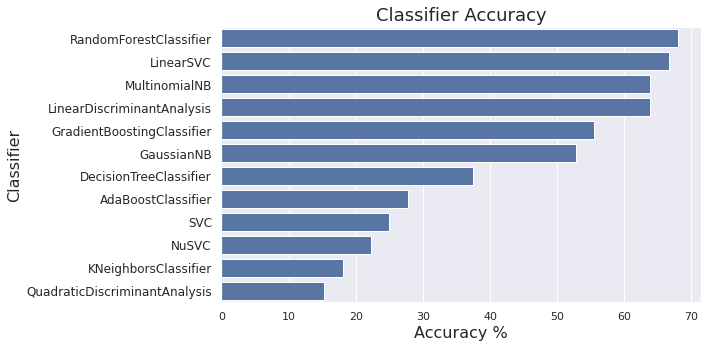

In [68]:
classifiers = [
    KNeighborsClassifier(9),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    LinearSVC(max_iter = 100000, dual=False),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators= 150),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    MultinomialNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy"]
log_df = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y)
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)

    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log_df = log_df.append(log_entry)

# sort by accuracy
log_df.sort_values(by='Accuracy', ascending = False, inplace=True)

plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(x='Accuracy', y='Classifier', data=log_df, color="b")

ax.set_xlabel('Accuracy %',fontsize=16)
ax.set_ylabel('Classifier',fontsize=16)
ax.set_title('Classifier Accuracy',fontsize=18)
plt.yticks(size=12)
plt.show()

##### after several runs, the accuracy for 5 models are consistently higher than the rest: LinearSVC, RandomForest, GradientBoost, NultinomialNB, and LinearDiscriminantAnalysis. We can proceed and check the accuracy for a few different ways of running each

### Process
For each of the identified models we will do the following:
1. perform 100 runs and collect the avg accuracy and best accuracy<br>
2. add data to accuracy_summary_df<br>
3. chart the accuracy distribution<br>
4. run cross validation with 5 and 10 splits, show average accuracy an best accuracy, observe that they are not signficantly different than the 100 runs. We won't chart it<br>
5. classify the per curiam decisions by the avg and best accuracy<br>
6. add data to avg_classification_df and best_classification_df<br>

finally, we wll display the dataframes

#### process setup

In [9]:
accuracy_columns = ['Classifier', 'Mean Accuracy', 'Best Accuracy']
accuracy_summary_df = pd.DataFrame(columns=accuracy_columns)

classification_columns = ['Classifier']
classification_columns.extend(sorted(justice_names))
mean_classification_df = pd.DataFrame(columns=classification_columns)
best_classification_df = pd.DataFrame(columns=classification_columns)

### LinearSVC

#### 1) 100 runs

In [10]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_100(X=X, y=y, model='LinearSVC')

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['LinearSVC', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.6288
ACCURACY STD: 0.05
HIGHEST ACCURACY: 0.7361


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,62.88,73.61


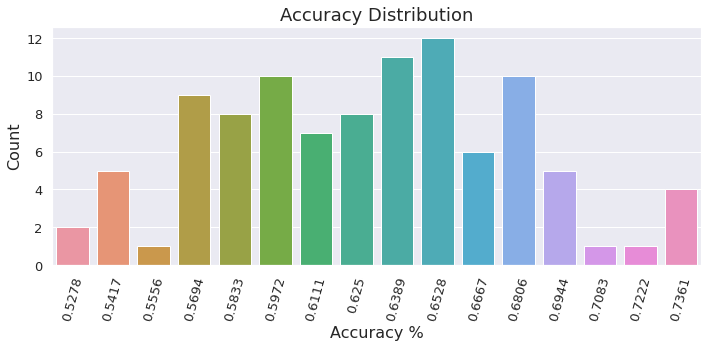

In [11]:
# now, let chart the accuracy distribution of the 100 runs
chart_results(accuracy_score_list)

#### 2) cross validation with RepeatedStratifiedKFold
##### we'll run 50 repeats and 5 and 10 splits

In [13]:
# now with 5 splits
scores = run_cross_validation(X=X, y=y, model=LinearSVC(max_iter = 100000, dual=False), splits=5, repeats=100)

cross validation Training score mean: 0.6268
cross validation Training score std: 0.0495


In [14]:
# now with 10 splits
scores = run_cross_validation(X=X, y=y, model=LinearSVC(max_iter = 100000, dual=False), splits=10, repeats=100)

cross validation Training score mean: 0.6405
cross validation Training score std: 0.0704


In [16]:
# chart accuracy distribution
#chart_results(scores)

#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>


In [15]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, avg_model, 'LinearSVC', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.625
index of closest accuracy score: 20
closest accuracy score found 8 times
indexes: [20 23 53 61 69 73 82 87]
choosing model from index: 69


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,1,0,0,0,3,10,5,0,16


In [16]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, best_model, 'LinearSVC', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [ 7 11 26 40]
max accuracy: 40
choosing model from index: 0.7361111111111112


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,0,0,0,1,8,0,8,2,16


### Random Forest


#### 1) 100 runs

In [17]:
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_100(X=X, y=y, model='RandomForest')

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['RandomForest', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)

AVERAGE ACCURACY: 0.6007
ACCURACY STD: 0.0421
HIGHEST ACCURACY: 0.7361


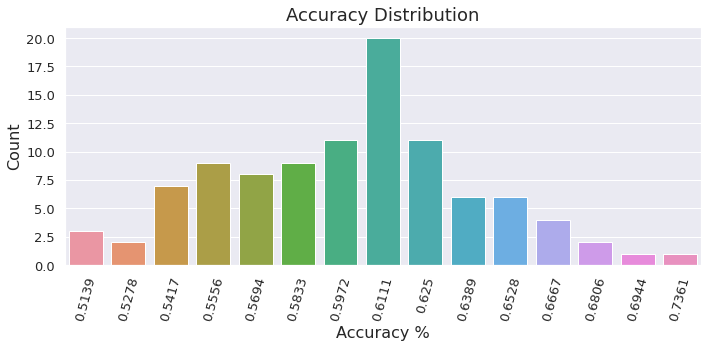

In [18]:
# now, let chart the accuracy distribution of the 100 runs
chart_results(accuracy_score_list)

#### 2) cross validation with RepeatedStratifiedKFold
##### we'll run 50 repeats and 5 and 10 splits

In [19]:
# run model with 5 splits
scores = run_cross_validation(X=X, y=y, model=RandomForestClassifier(n_estimators= 150), splits=5, repeats=100)

cross validation Training score mean: 0.6072
cross validation Training score std: 0.0493


In [20]:
# run model with 10 splits
scores = run_cross_validation(X=X, y=y, model=RandomForestClassifier(n_estimators= 150), splits=10, repeats=100)

cross validation Training score mean: 0.6187
cross validation Training score std: 0.0721


#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [21]:
#chart_per_curiams(curiam_df, curiam_predict_df, best_model, justices_map)
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, avg_model, 'RandomForest', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.5972222222222222
index of closest accuracy score: 6
closest accuracy score found 11 times
indexes: [ 6 13 14 18 26 49 53 62 74 94 95]
choosing model from index: 18


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,1,0,0,0,3,10,5,0,16
0,RandomForest,0,8,15,0,4,8,0,0,0


In [22]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, best_model, 'RandomForest', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [5]
max accuracy: 5
choosing model from index: 0.7361111111111112


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,0,0,0,1,8,0,8,2,16
0,RandomForest,0,5,4,0,9,13,3,0,1


### MultinomialNB

#### 1) 100 runs

In [23]:
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_100(X=X, y=y, model='MultinomialNB')

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['MultinomialNB', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)

AVERAGE ACCURACY: 0.5972
ACCURACY STD: 0.0545
HIGHEST ACCURACY: 0.7083


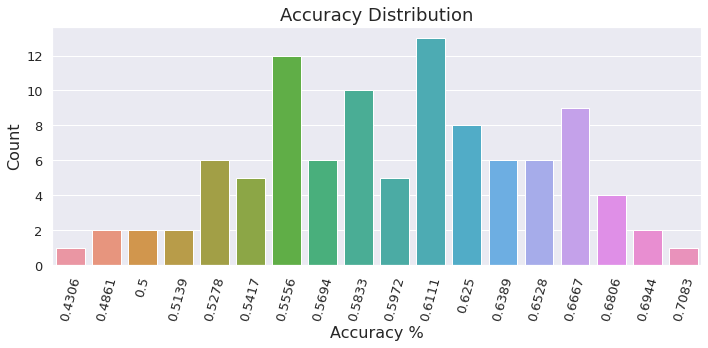

In [24]:
# now, let chart the accuracy distribution of the 100 runs
chart_results(accuracy_score_list)

#### 2) cross validation with RepeatedStratifiedKFold
##### we'll run 50 repeats and 5 and 10 splits

In [25]:
# run model with 5 splits
scores = run_cross_validation(X=X, y=y, model=MultinomialNB(), splits=5, repeats=100)

cross validation Training score mean: 0.5937
cross validation Training score std: 0.0505


In [26]:
# run model with 10 splits
scores = run_cross_validation(X=X, y=y, model=MultinomialNB(), splits=10, repeats=100)

cross validation Training score mean: 0.5988
cross validation Training score std: 0.0729


#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [27]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, avg_model, 'MultinomialNB', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.5972222222222222
index of closest accuracy score: 15
closest accuracy score found 5 times
indexes: [15 67 76 90 91]
choosing model from index: 90


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,1,0,0,0,3,10,5,0,16
0,RandomForest,0,8,15,0,4,8,0,0,0
0,MultinomialNB,2,0,5,0,2,9,17,0,0


In [28]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, best_model, 'MultinomialNB', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [8]
max accuracy: 8
choosing model from index: 0.7083333333333334


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,0,0,0,1,8,0,8,2,16
0,RandomForest,0,5,4,0,9,13,3,0,1
0,MultinomialNB,2,0,3,0,6,10,13,0,1


### GradientBoosting

#### 100 runs

In [29]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_100(X=X, y=y, model='GradientBoosting')

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['GradientBoosting', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)

AVERAGE ACCURACY: 0.5521
ACCURACY STD: 0.0459
HIGHEST ACCURACY: 0.6667


#### 2) cross validation with RepeatedStratifiedKFold
##### we'll run 50 repeats and 5 and 10 splits

In [30]:
# run model with 5 splits
scores = run_cross_validation(X=X, y=y, model=GradientBoostingClassifier(), splits=5, repeats=100)

cross validation Training score mean: 0.5484
cross validation Training score std: 0.0541


In [31]:
# run model with 10 splits
scores = run_cross_validation(X=X, y=y, model=GradientBoostingClassifier(), splits=10, repeats=100)

cross validation Training score mean: 0.5641
cross validation Training score std: 0.074


#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [32]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, avg_model, 'GradientBoosting', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.5555555555555556
index of closest accuracy score: 8
closest accuracy score found 12 times
indexes: [ 8 29 31 33 47 57 69 71 75 85 95 97]
choosing model from index: 97


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,1,0,0,0,3,10,5,0,16
0,RandomForest,0,8,15,0,4,8,0,0,0
0,MultinomialNB,2,0,5,0,2,9,17,0,0
0,GradientBoosting,0,2,10,0,11,12,0,0,0


In [33]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, best_model, 'GradientBoosting', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [43]
max accuracy: 43
choosing model from index: 0.6666666666666666


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,0,0,0,1,8,0,8,2,16
0,RandomForest,0,5,4,0,9,13,3,0,1
0,MultinomialNB,2,0,3,0,6,10,13,0,1
0,GradientBoosting,7,0,11,0,10,7,0,0,0


### LinearDiscriminantAnalysis

#### 100 runs

In [34]:
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_100(X=X, y=y, model='LDA')

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['LDA', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)

AVERAGE ACCURACY: 0.5664
ACCURACY STD: 0.0557
HIGHEST ACCURACY: 0.7222


#### 2) cross validation with RepeatedStratifiedKFold
##### we'll run 50 repeats and 5 and 10 splits

In [35]:
# run model with 5 splits
scores = run_cross_validation(X=X, y=y, model=LinearDiscriminantAnalysis(), splits=5, repeats=100)

cross validation Training score mean: 0.5551
cross validation Training score std: 0.0543


In [36]:
# run model with 10 splits
scores = run_cross_validation(X=X, y=y, model=LinearDiscriminantAnalysis(), splits=10, repeats=100)

cross validation Training score mean: 0.5918
cross validation Training score std: 0.0758


#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [37]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, avg_model, 'LDA', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.5694444444444444
index of closest accuracy score: 21
closest accuracy score found 11 times
indexes: [21 26 30 38 46 48 64 65 86 89 98]
choosing model from index: 30


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,1,0,0,0,3,10,5,0,16
0,RandomForest,0,8,15,0,4,8,0,0,0
0,MultinomialNB,2,0,5,0,2,9,17,0,0
0,GradientBoosting,0,2,10,0,11,12,0,0,0
0,LDA,1,2,1,1,11,2,6,1,10


In [38]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_df, curiam_predict_df, best_model, 'LDA', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [57]
max accuracy: 57
choosing model from index: 0.7222222222222222


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,0,0,0,1,8,0,8,2,16
0,RandomForest,0,5,4,0,9,13,3,0,1
0,MultinomialNB,2,0,3,0,6,10,13,0,1
0,GradientBoosting,7,0,11,0,10,7,0,0,0
0,LDA,1,1,0,0,18,0,2,1,12


### Visualizations
At this point we have 3 dataframes with summary/aggregate information

In [ ]:
# le's see how the accuracies compare

In [39]:
accuracy_summary_df

,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,62.88,73.61
0,RandomForest,60.07,73.61
0,MultinomialNB,59.72,70.83
0,GradientBoosting,55.21,66.67
0,LDA,56.64,72.22


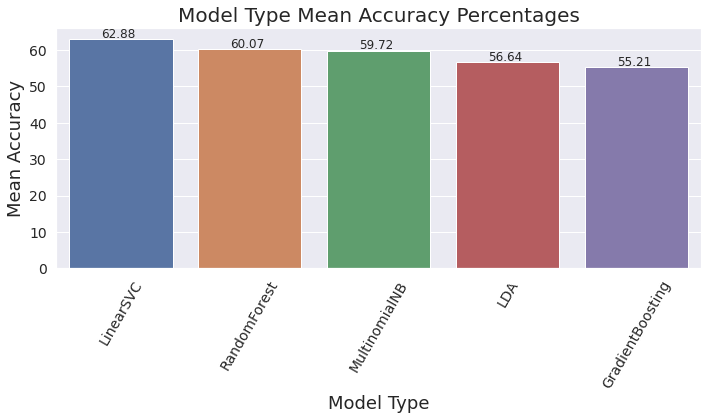

In [51]:
asd_by_mean_df = accuracy_summary_df.sort_values(by='Mean Accuracy', ascending = False)
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='Mean Accuracy', x="Classifier", data = asd_by_mean_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Model Type',fontsize=18)
ax.set_ylabel('Mean Accuracy',fontsize=18)
ax.set_title('Model Type Mean Accuracy Percentages',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

In [ ]:
asd_by_best_df = accuracy_summary_df.sort_values(by='Best Accuracy', ascending = False)
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='Best Accuracy', x="Classifier", data = asd_by_best_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Model Type',fontsize=18)
ax.set_ylabel('Best Accuracy',fontsize=18)
ax.set_title('Model Type Best Accuracy Percentages',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

#### We can visualize the per curiam classifications by model type (avg, best) or classifier name
There are ten in total, so viewing all of them would be impracticaly. The dataframe view shows the large differences in how the per curiams were classified

In [53]:
mean_classification_df

,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,1,0,0,0,3,10,5,0,16
0,RandomForest,0,8,15,0,4,8,0,0,0
0,MultinomialNB,2,0,5,0,2,9,17,0,0
0,GradientBoosting,0,2,10,0,11,12,0,0,0
0,LDA,1,2,1,1,11,2,6,1,10


In [54]:
best_classification_df

,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,0,0,0,1,8,0,8,2,16
0,RandomForest,0,5,4,0,9,13,3,0,1
0,MultinomialNB,2,0,3,0,6,10,13,0,1
0,GradientBoosting,7,0,11,0,10,7,0,0,0
0,LDA,1,1,0,0,18,0,2,1,12


TypeError: chart_per_curiams() takes 2 positional arguments but 3 were given

### Discussion
This was an interesting implementation of several models. I am not surprised that the cross validation runs did not differ much from the 100 standard runs since the latter is effectively a different way of doing the former. The overall average accuracy scores are fairly consistent as are the overall best accuracy scores. I don't know what to make of that. I don't know if it is reasonable to expect greater differences or not. Given that the ultimate goal of each model is to find the best fit, it could be that the tight scores are confirmation that the models are working as designed and given the data, it reinforces that the calculated scores are accurate.<br><br>
A few of the judges appeared repeatedly in the per curiam classification counts (Kennedy, Roberts, Ginsburg, Scalia, and Thomas). Three minimally (Kagan, Sotomayor, and Breyer). Given the lack of consistency and the resulting values being highly train/test split dependent, my guess is that subsequent runs would produce entirely different results.<br><br>
Another thing that greatly surprised me is that, given the consistency of the accuracy scores for both the mean and the best, I would have expected the classifications to be more consistent. However, that is not the case. See the following charts

##### first a comparison between two mean model types

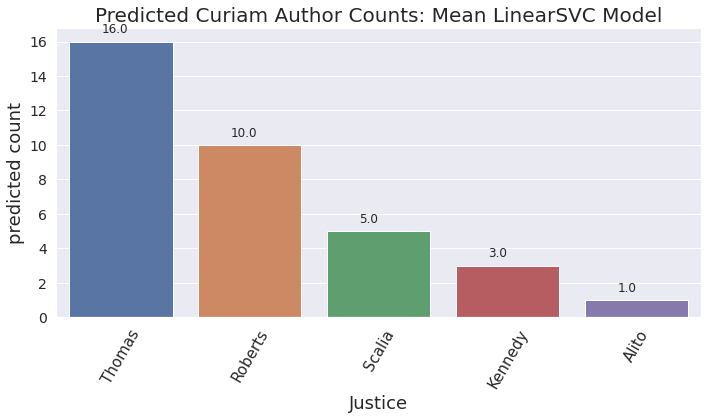

In [62]:
chart_per_curiams(mean_classification_df, 'LinearSVC', 'Mean')

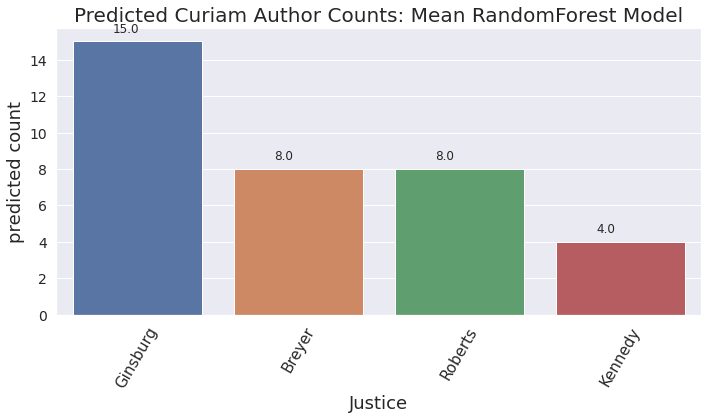

In [63]:
chart_per_curiams(mean_classification_df, 'RandomForest', 'Mean')

##### first a comparison between two mean model types

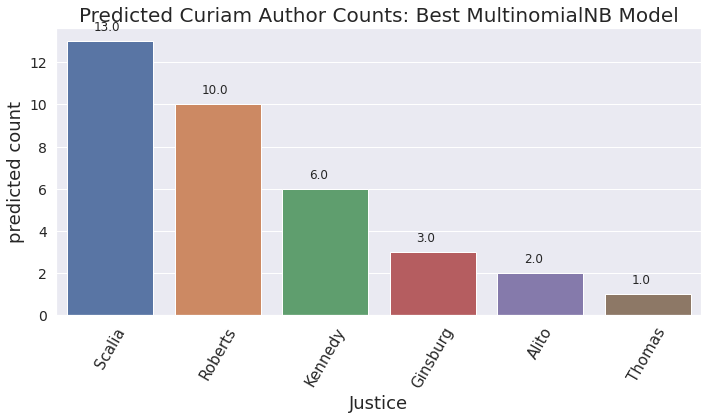

In [64]:
chart_per_curiams(best_classification_df, 'MultinomialNB', 'Best')

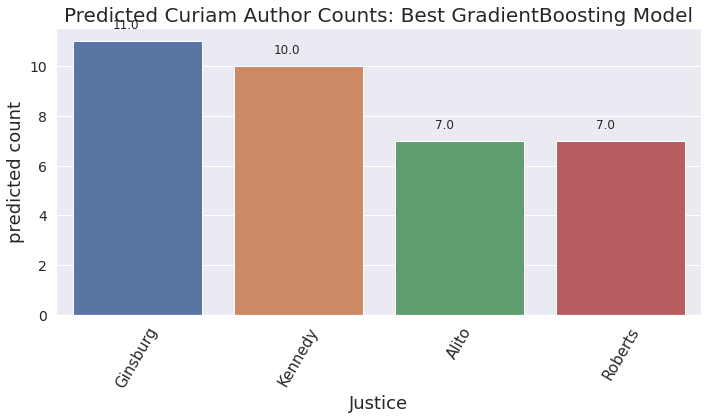

In [65]:
chart_per_curiams(best_classification_df, 'GradientBoosting', 'Best')